In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Laurence_Fishburne_4.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kate_Capshaw_2.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Larry_Nichols_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Norman_Mineta_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kweisi_Mfume_1.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Oliver_Phelps_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube

In [2]:
import torch
import torchvision

In [3]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

   2199    2199   45153


In [4]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
#data_dir = '/kaggle/input/faceid-preprocessed'

In [5]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

videoID      personName  imageHeight  imageWidth  \
0      Alison_Lohman_0   Alison_Lohman        228.0       213.0   
1      Alison_Lohman_1   Alison_Lohman        248.0       201.0   
2      Alison_Lohman_2   Alison_Lohman        335.0       308.0   
3      Alison_Lohman_3   Alison_Lohman        151.0       110.0   
4      Alison_Lohman_4   Alison_Lohman        236.0       228.0   
...                ...             ...          ...         ...   
2189    Yossi_Beilin_3    Yossi_Beilin        240.0       243.0   
2190      Zahir_Shah_0      Zahir_Shah        196.0       200.0   
2191      Zahir_Shah_1      Zahir_Shah        240.0       293.0   
2192  Zoran_Djindjic_0  Zoran_Djindjic        230.0       237.0   
2193  Zoran_Djindjic_2  Zoran_Djindjic        131.0       115.0   

      videoDuration  averageFaceSize  numVideosForPerson  
0             240.0        90.150000                 6.0  
1              79.0       108.417722                 6.0  
2             136.0       122.161765                 6.0  
3              53.0        58.000000                 6.0  
4             147.0        91.680272                 6.0  
...             ...              ...                 ...  
2189          240.0       110.258333                 2.0  
2190          143.0        93.944056                 2.0  
2191          240.0       155.495833                 2.0  
2192          240.0        98.908333                 2.0  
2193          240.0        59.554167                 2.0  

[2194 rows x 7 columns]

In [6]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [7]:
import random
import pickle

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        need_preprocessing = []
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    need_preprocessing += [fp]
        if preprocess:
            preprocessed = [self._preprocess(fp) for fp in tqdm(need_preprocessing, desc='Preprocessing')]
            self.preprocessed_cache = dict((fp, self._load_preprocessed(pfp)) for fp, pfp in tqdm(preprocessed, desc='Loading data'))
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return (fp, pfp)
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

#dataset = YouTubeFacesDataset(df, data_dir, preprocess = True)
dataset = YouTubeFacesDataset(df, data_dir, cache_lim = 1)
len(dataset)

Loading data: 100% 828/828 [00:02<00:00, 363.24it/s]


828

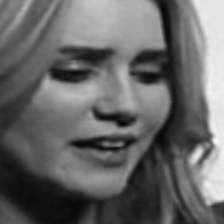

In [8]:
to_pil = torchvision.transforms.ToPILImage()
to_pil(dataset[0][0])

In [9]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [10]:
def validate(model_f, cnt = 20):
    model = torch.load(model_f, map_location=torch.device('cpu'))
    _, axs = plt.subplots(nrows=cnt, ncols=3, figsize=(3*4, cnt*4))
    for i in range(cnt):
        idx = random.randint(0, len(dataset)-1)
        img1, img2, img3 = dataset[idx]
        v1 = model(img1.reshape(1, 1, 224, 224)).detach().numpy()
        v2 = model(img2.reshape(1, 1, 224, 224)).detach().numpy()
        v3 = model(img3.reshape(1, 1, 224, 224)).detach().numpy()
        title = '%d %f %f %f %f %f %f' % (idx,
            euc_similarity(v1, v2), euc_similarity(v1, v3),
            cos_similarity(v1, v2), cos_similarity(v1, v3),
            np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())
        plt.sca(axs[i, 0])
        plt.imshow(img1.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.sca(axs[i, 1])
        plt.imshow(img2.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.title(title)
        plt.sca(axs[i, 2])
        plt.imshow(img3.reshape(224, 224), cmap='gray')
        plt.axis('off')
        print(title)

506 3.812409 13.350932 0.923781 0.322573 -5.707901 4.909510
230 3.667843 17.752499 0.982823 -0.425031 -7.115597 6.060853
511 2.187187 6.771830 0.972605 0.763593 -5.191437 3.257412
799 3.550161 4.043674 0.940505 0.949092 -5.500492 4.327462
663 2.400681 9.141639 0.966657 0.261593 -3.952220 3.768652
303 4.781528 5.405927 0.875858 0.866107 -5.187562 3.898136
368 5.136156 7.782190 0.862187 0.682973 -7.632236 4.942721
541 3.095708 6.040811 0.970375 0.894175 -6.888399 6.106304
41 6.331641 9.478656 0.714763 0.131376 -4.304105 5.000176
262 1.845717 5.541905 0.939174 0.727449 -3.697192 3.241917
586 4.658138 9.792831 0.471661 0.053229 -3.990010 3.914834
504 3.753087 3.651404 0.854781 0.897636 -3.674560 2.674634
640 3.241774 9.940759 0.950000 0.303507 -4.137342 4.461720
775 2.024393 9.120246 0.972256 0.458508 -4.612233 3.770493
640 2.711412 20.394041 0.976437 -0.298698 -7.811110 4.807278
271 6.641266 8.662448 0.260802 0.020644 -3.766863 4.356784
513 3.113220 7.431834 0.958368 0.607693 -4.634941 4.

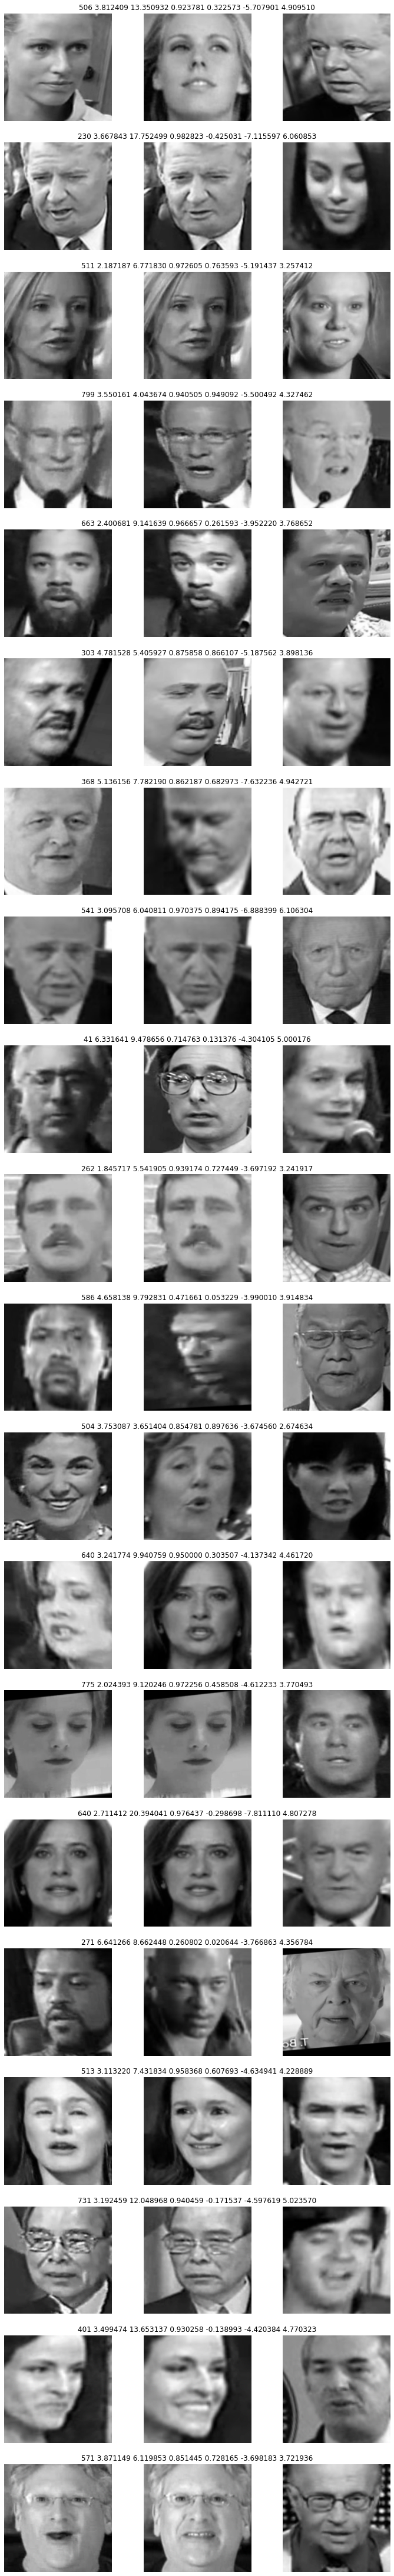

In [11]:
validate('faceid-model-0.016750329740267147.pt')

369 1.963024 15.826204 0.986850 -0.046238 -7.519638 4.252024
72 6.702038 6.844651 0.619590 0.537946 -4.858142 3.083648
826 2.011201 11.866812 0.933443 0.006244 -5.383597 3.314915
83 5.454842 8.151804 0.666459 0.263361 -3.956258 3.000071
344 5.172837 8.156830 0.805949 0.306752 -4.129928 4.731334
528 2.281430 9.247578 0.975503 0.031133 -4.188541 3.871813
185 1.608441 8.382004 0.984560 0.475181 -5.963081 2.959535
335 3.452514 8.360097 0.894817 0.786995 -6.705147 6.097808
171 5.336536 8.977874 0.793949 0.594125 -4.730639 3.948358
808 3.485794 10.022016 0.900121 0.301863 -5.167598 3.254917
823 2.662105 10.334552 0.915042 0.071316 -4.022965 3.497919
313 4.092831 5.383344 0.810012 0.636440 -3.946773 2.530257
256 2.868884 11.911568 0.905780 -0.366145 -3.480713 3.881366
294 2.658953 6.272015 0.950889 0.768922 -5.000951 5.071835
302 2.530072 12.679263 0.898062 -0.093103 -4.392948 5.421421
21 5.266900 8.973976 0.785993 0.380603 -3.696038 3.289975
825 3.340317 6.249169 0.924355 0.697149 -5.572076 

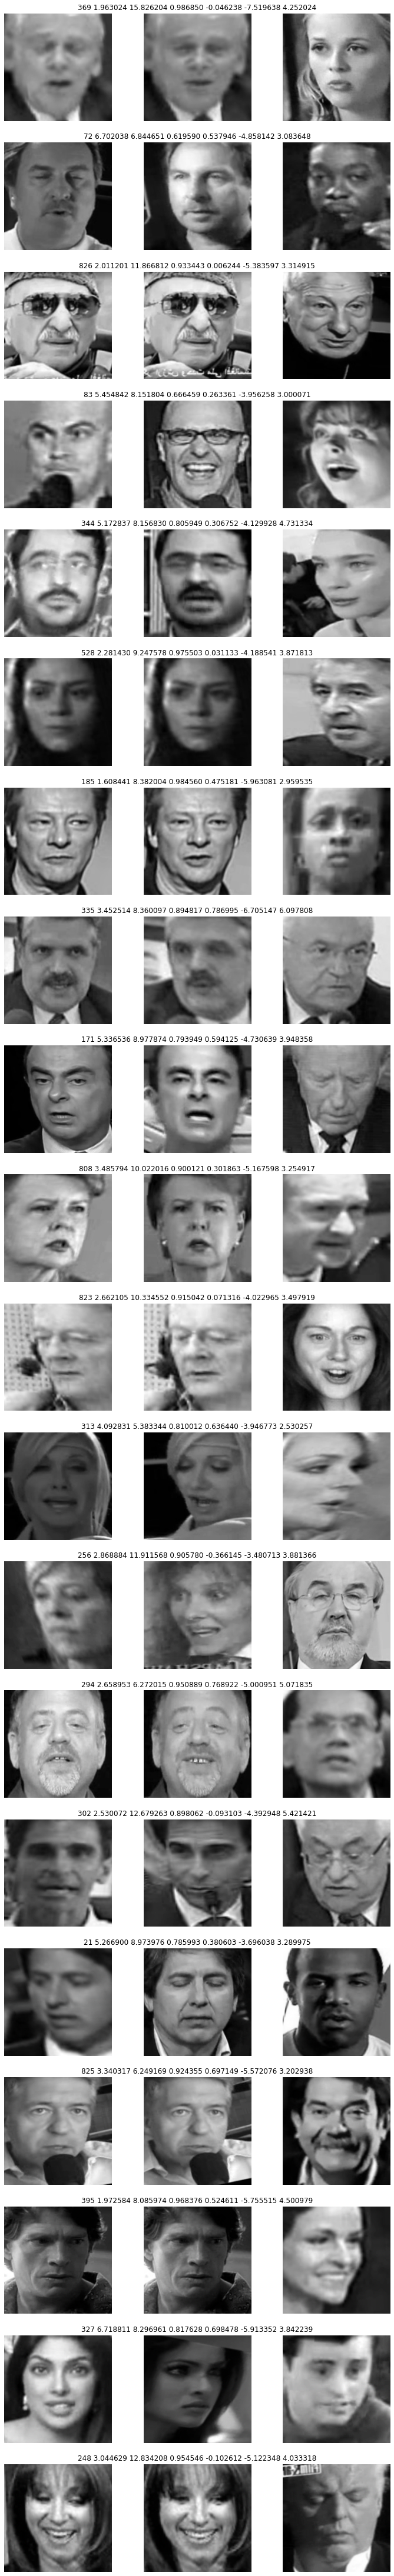

In [12]:
validate('faceid-model-0.02253507034381968.pt')

221 2.546134 15.111187 0.977759 0.000060 -6.284045 5.408445
726 3.848684 10.972381 0.839420 0.080088 -4.580280 3.275640
481 1.853042 10.500360 0.971189 0.263081 -5.709248 5.451874
408 3.222654 5.724487 0.889492 0.725957 -4.130688 4.551392
167 2.665435 8.160893 0.960204 0.640817 -4.924958 4.139740
682 5.031229 5.268277 0.910885 0.902718 -5.348025 5.132520
247 2.097469 7.485828 0.971825 0.582864 -5.176899 4.035091
508 4.745987 10.817425 0.616608 0.174777 -4.561433 3.733025
691 4.244218 8.604711 0.843020 0.316828 -3.555235 3.729414
198 8.286132 15.955299 0.752780 -0.182839 -3.920759 6.527450
80 3.072041 16.121857 0.968592 -0.064416 -6.653101 4.958012
806 3.980582 7.736522 0.841018 0.848754 -5.797269 3.331642
654 3.279688 8.752307 0.954494 0.589660 -4.943815 5.157270
425 3.583108 7.950868 0.925798 0.551721 -3.568113 3.694613
565 5.453980 7.320988 0.485996 0.765079 -5.864402 4.751861
313 5.180234 7.924386 0.845450 0.745474 -5.587683 4.664859
500 1.493342 16.669811 0.993798 -0.485849 -7.0537

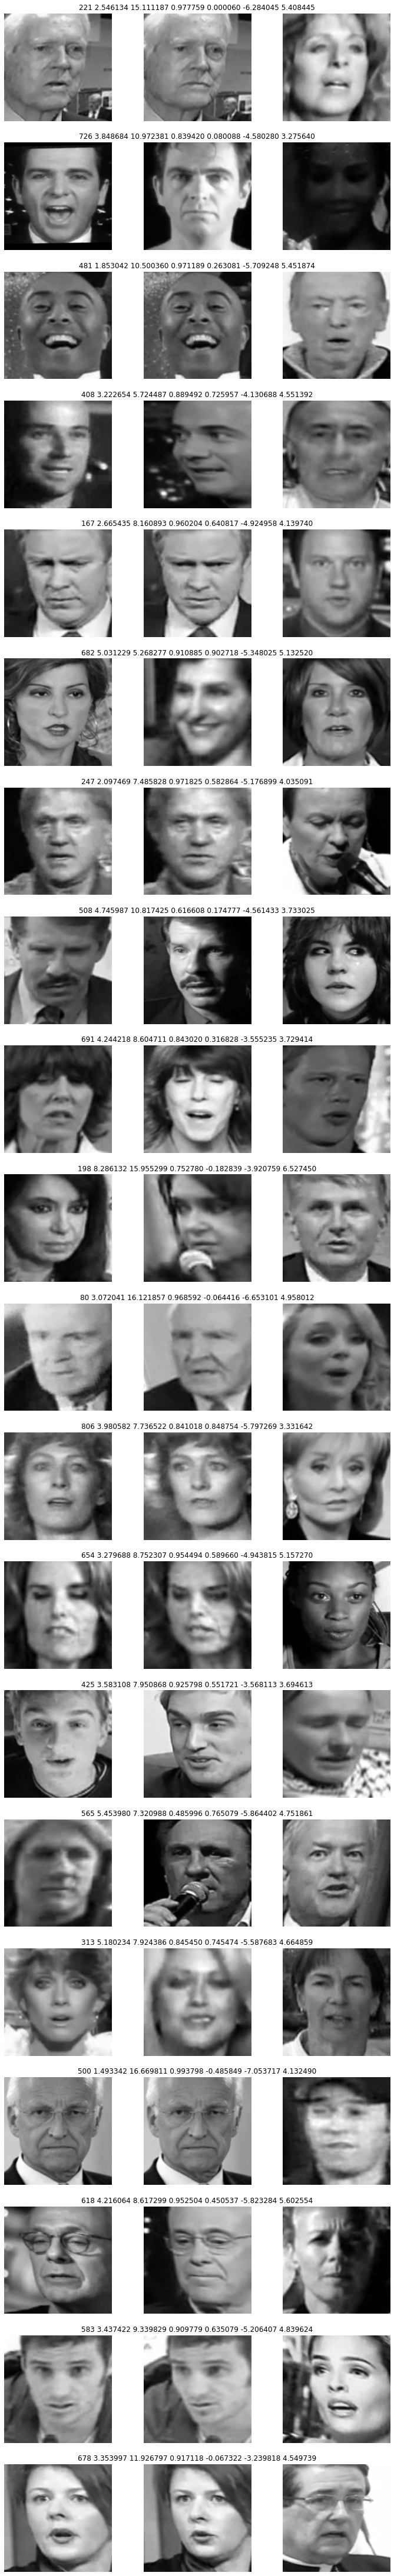

In [13]:
validate('faceid-model-0.011796065969605762.pt')